<a href="https://colab.research.google.com/github/dk3156/Dongje-Kim-AI/blob/final_takehome/final_takehome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout, Input


#Display plots directly in the notebook
%matplotlib inline
# Configuration to imporve the resolution of the plots
%config InlineBackend.figure_format='retina'
# Default style for seaborn plots with a white grid and muted colors, and scales the font size by 1.5 times
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
#sets the default figure size to 16 inches by 10 inches
rcParams['figure.figsize'] = 16, 10

# Data

In [ ]:
# Original Data Source: https://fred.stlouisfed.org/series/RSXFSN
# importing google colab library so that the user can upload the file locally
from google.colab import files
#storing local file on the notebook
uploaded = files.upload()

Saving RSXFSN.csv to RSXFSN.csv


In [ ]:
# Store data in DataFrame
df = pd.read_csv("RSXFSN.csv")

In [ ]:
# keep real GDP only
# Extracting 'RSXFSN' column from the data file
keep_columns = ['RSXFSN']
df = df[keep_columns]
# rescaling each value by a factor of 10000
df = df/10000

# Data Preprocessing

In [ ]:
# split train & test data
# 80 percent of the whole dataset will be converted to training set
n_train = int(len(df) * 0.8)
# 20 percent of the data set to testing set
n_test = len(df) - n_train
# The first n_train rows of the dataset assigned to training set
# The rest of the rows assigned to testing set
# Partitioning data using iloc method
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]
print(len(train), len(test))

In [ ]:
# Converting dataframe x into a time series dataset
# x_ts is an input component, with elements n_samples, n_steps, n_features
# y_ts is an output component, with elements n_sanmples, n_features
def get_timeseries(x, n_steps=1):
    #initializing to empty array
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        # Extracting input data consisting of current and previous n_steps time steps
        v = x.iloc[ii:(ii + n_steps)].values
        # Appending the input slice to x_ts
        x_ts.append(v)
        # Extracting the next time step value 
        w = x.iloc[ii + n_steps].values
        # Appending the value to y_ts
        y_ts.append(w)
    #return input and output components as numpy arrays
    return np.array(x_ts), np.array(y_ts)

In [ ]:
#Initializing number of timesteps and number of features 
n_steps = 16
n_features = 1

#Using get_timeseries function to convert training and testing dataframes into a format suitable for training a time series forecasting model
x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

#print dataframe dimensions
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

n_samples = len(x_train)
print(n_samples)

(284, 16, 1) (284, 1)
(59, 16, 1) (59, 1)
284


# Modeling - using CNN

In [111]:
#Initialze sequential class from keras library
model = Sequential()
#Add layer for specifying input dimensions
model.add(Input(shape=(n_steps, n_features)))
#Add three convolution layer
#Respectively with kernel size of 2, 3, 4 and 64, 32, 16 filters total. Using relu activation function
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', name="Conv1D_1")) #output = 10 rows
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2")) #output = 8 rows
model.add(Conv1D(filters=16, kernel_size=4, activation='relu', name="Conv1D_3")) #output = 7 rows
#Set dropout layer with value of 0.001
model.add(Dropout(0.001))
#Max pooling layer with size 2.
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D")) #output = 3rows
#Flatten the resulting array
model.add(Flatten())
#Dense layer with output units of 50
model.add(Dense(50, activation='relu'))
#Dense layer with output unit of 1
model.add(Dense(n_features))
#Compile with mean squared error as the loss function, with Adam optimizer of learning rate of 0.001
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae', 'mse'])
model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 15, 64)            192       
                                                                 
 Conv1D_2 (Conv1D)           (None, 13, 32)            6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 10, 16)            2064      
                                                                 
 dropout_13 (Dropout)        (None, 10, 16)            0         
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 5, 16)            0         
                                                                 
 flatten_13 (Flatten)        (None, 80)                0         
                                                                 
 dense_38 (Dense)            (None, 50)              

Training

In [103]:
# Train model on the training fata
# with specificed epoch, batchsize, validation, verbose, and shuffle parameter values
history = model.fit(x_train, y_train, epochs=500,validation_split=0.2, verbose=1)
     

Epoch 1/500
8/8 [==============================] - 2s 36ms/step - loss: 609.4282 - mae: 24.0038 - mse: 609.4282 - val_loss: 765.4761 - val_mae: 27.5096 - val_mse: 765.4761
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 198.7083 - mae: 13.1139 - mse: 198.7083 - val_loss: 9.7805 - val_mae: 2.4058 - val_mse: 9.7805
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 41.2430 - mae: 5.3326 - mse: 41.2430 - val_loss: 62.3256 - val_mae: 7.4225 - val_mse: 62.3256
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 12.6035 - mae: 2.7807 - mse: 12.6035 - val_loss: 40.2323 - val_mae: 5.7516 - val_mse: 40.2323
Epoch 5/500
8/8 [==============================] - 0s 10ms/step - loss: 15.3039 - mae: 3.2854 - mse: 15.3039 - val_loss: 7.0114 - val_mae: 1.8745 - val_mse: 7.0114
Epoch 6/500
8/8 [==============================] - 0s 9ms/step - loss: 10.5399 - mae: 2.6261 - mse: 10.5399 - val_loss: 11.3154 - val_mae: 2.8373 - val_mse: 11.3154
Ep

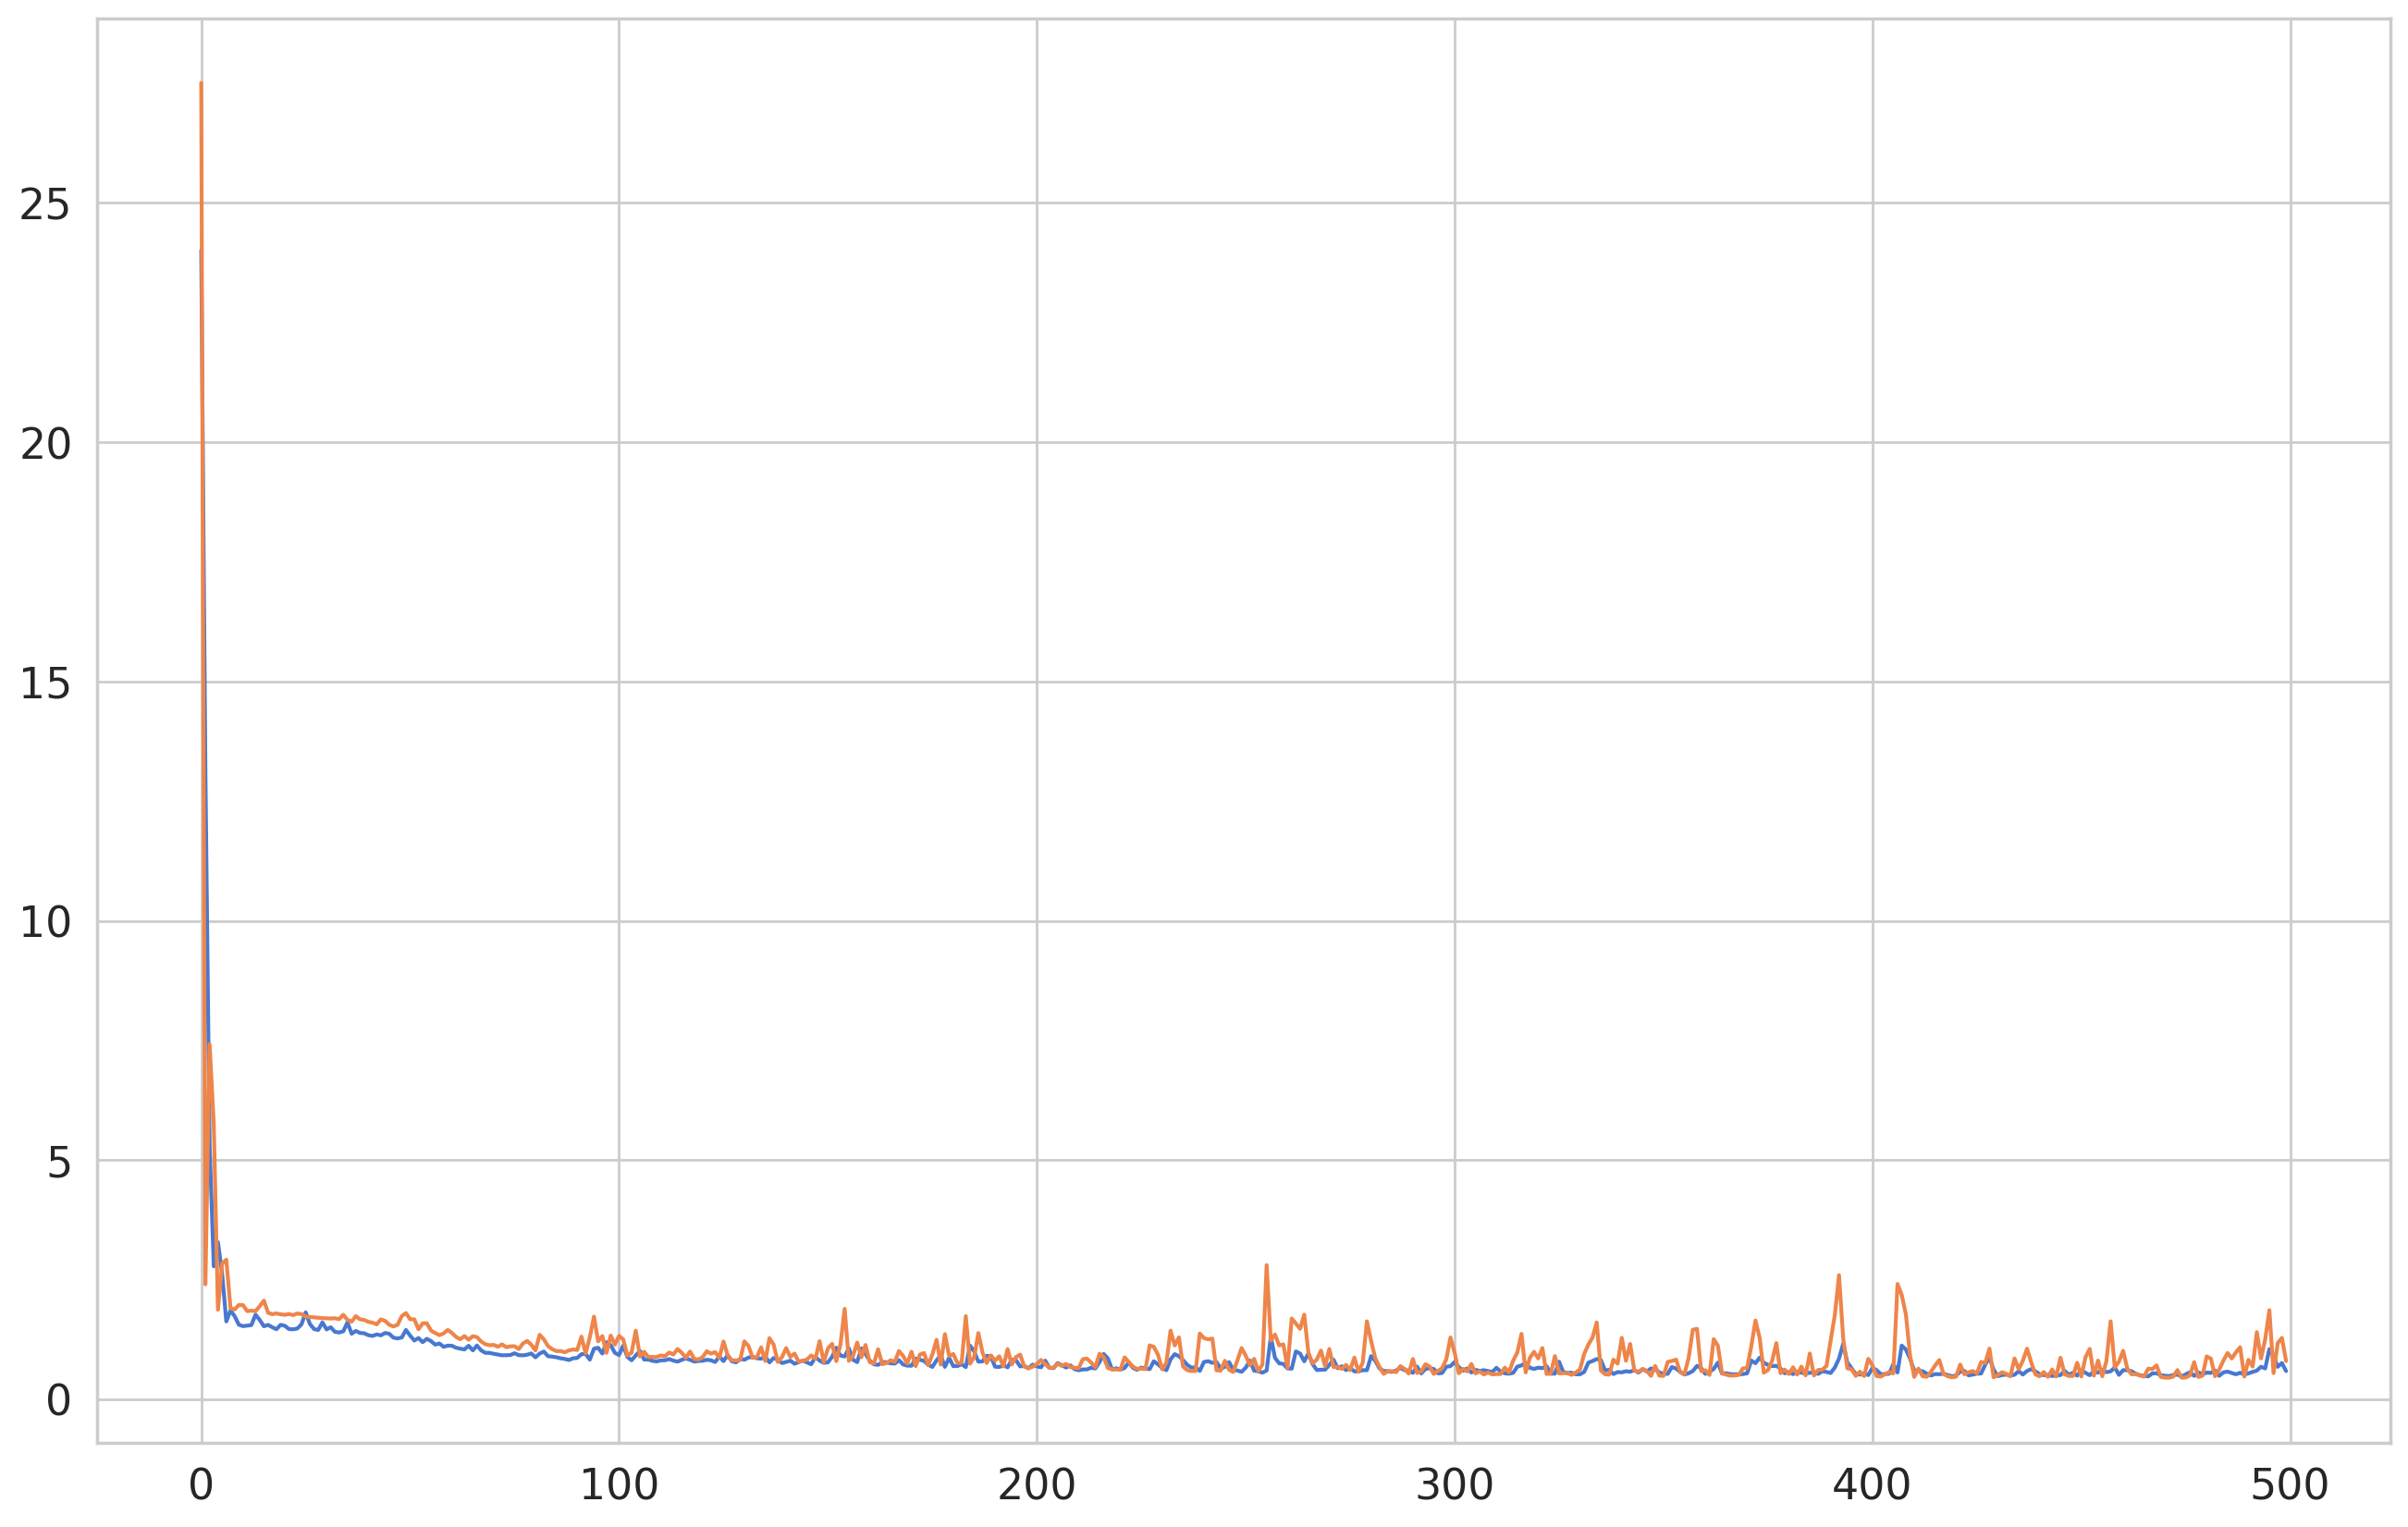

In [107]:
#Plot the mean absolute error difference
from matplotlib import pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [78]:
# Generate prediction for the test dataset
y_pred = model.predict(x_test)

2/2 [==============================] - 0s 10ms/step


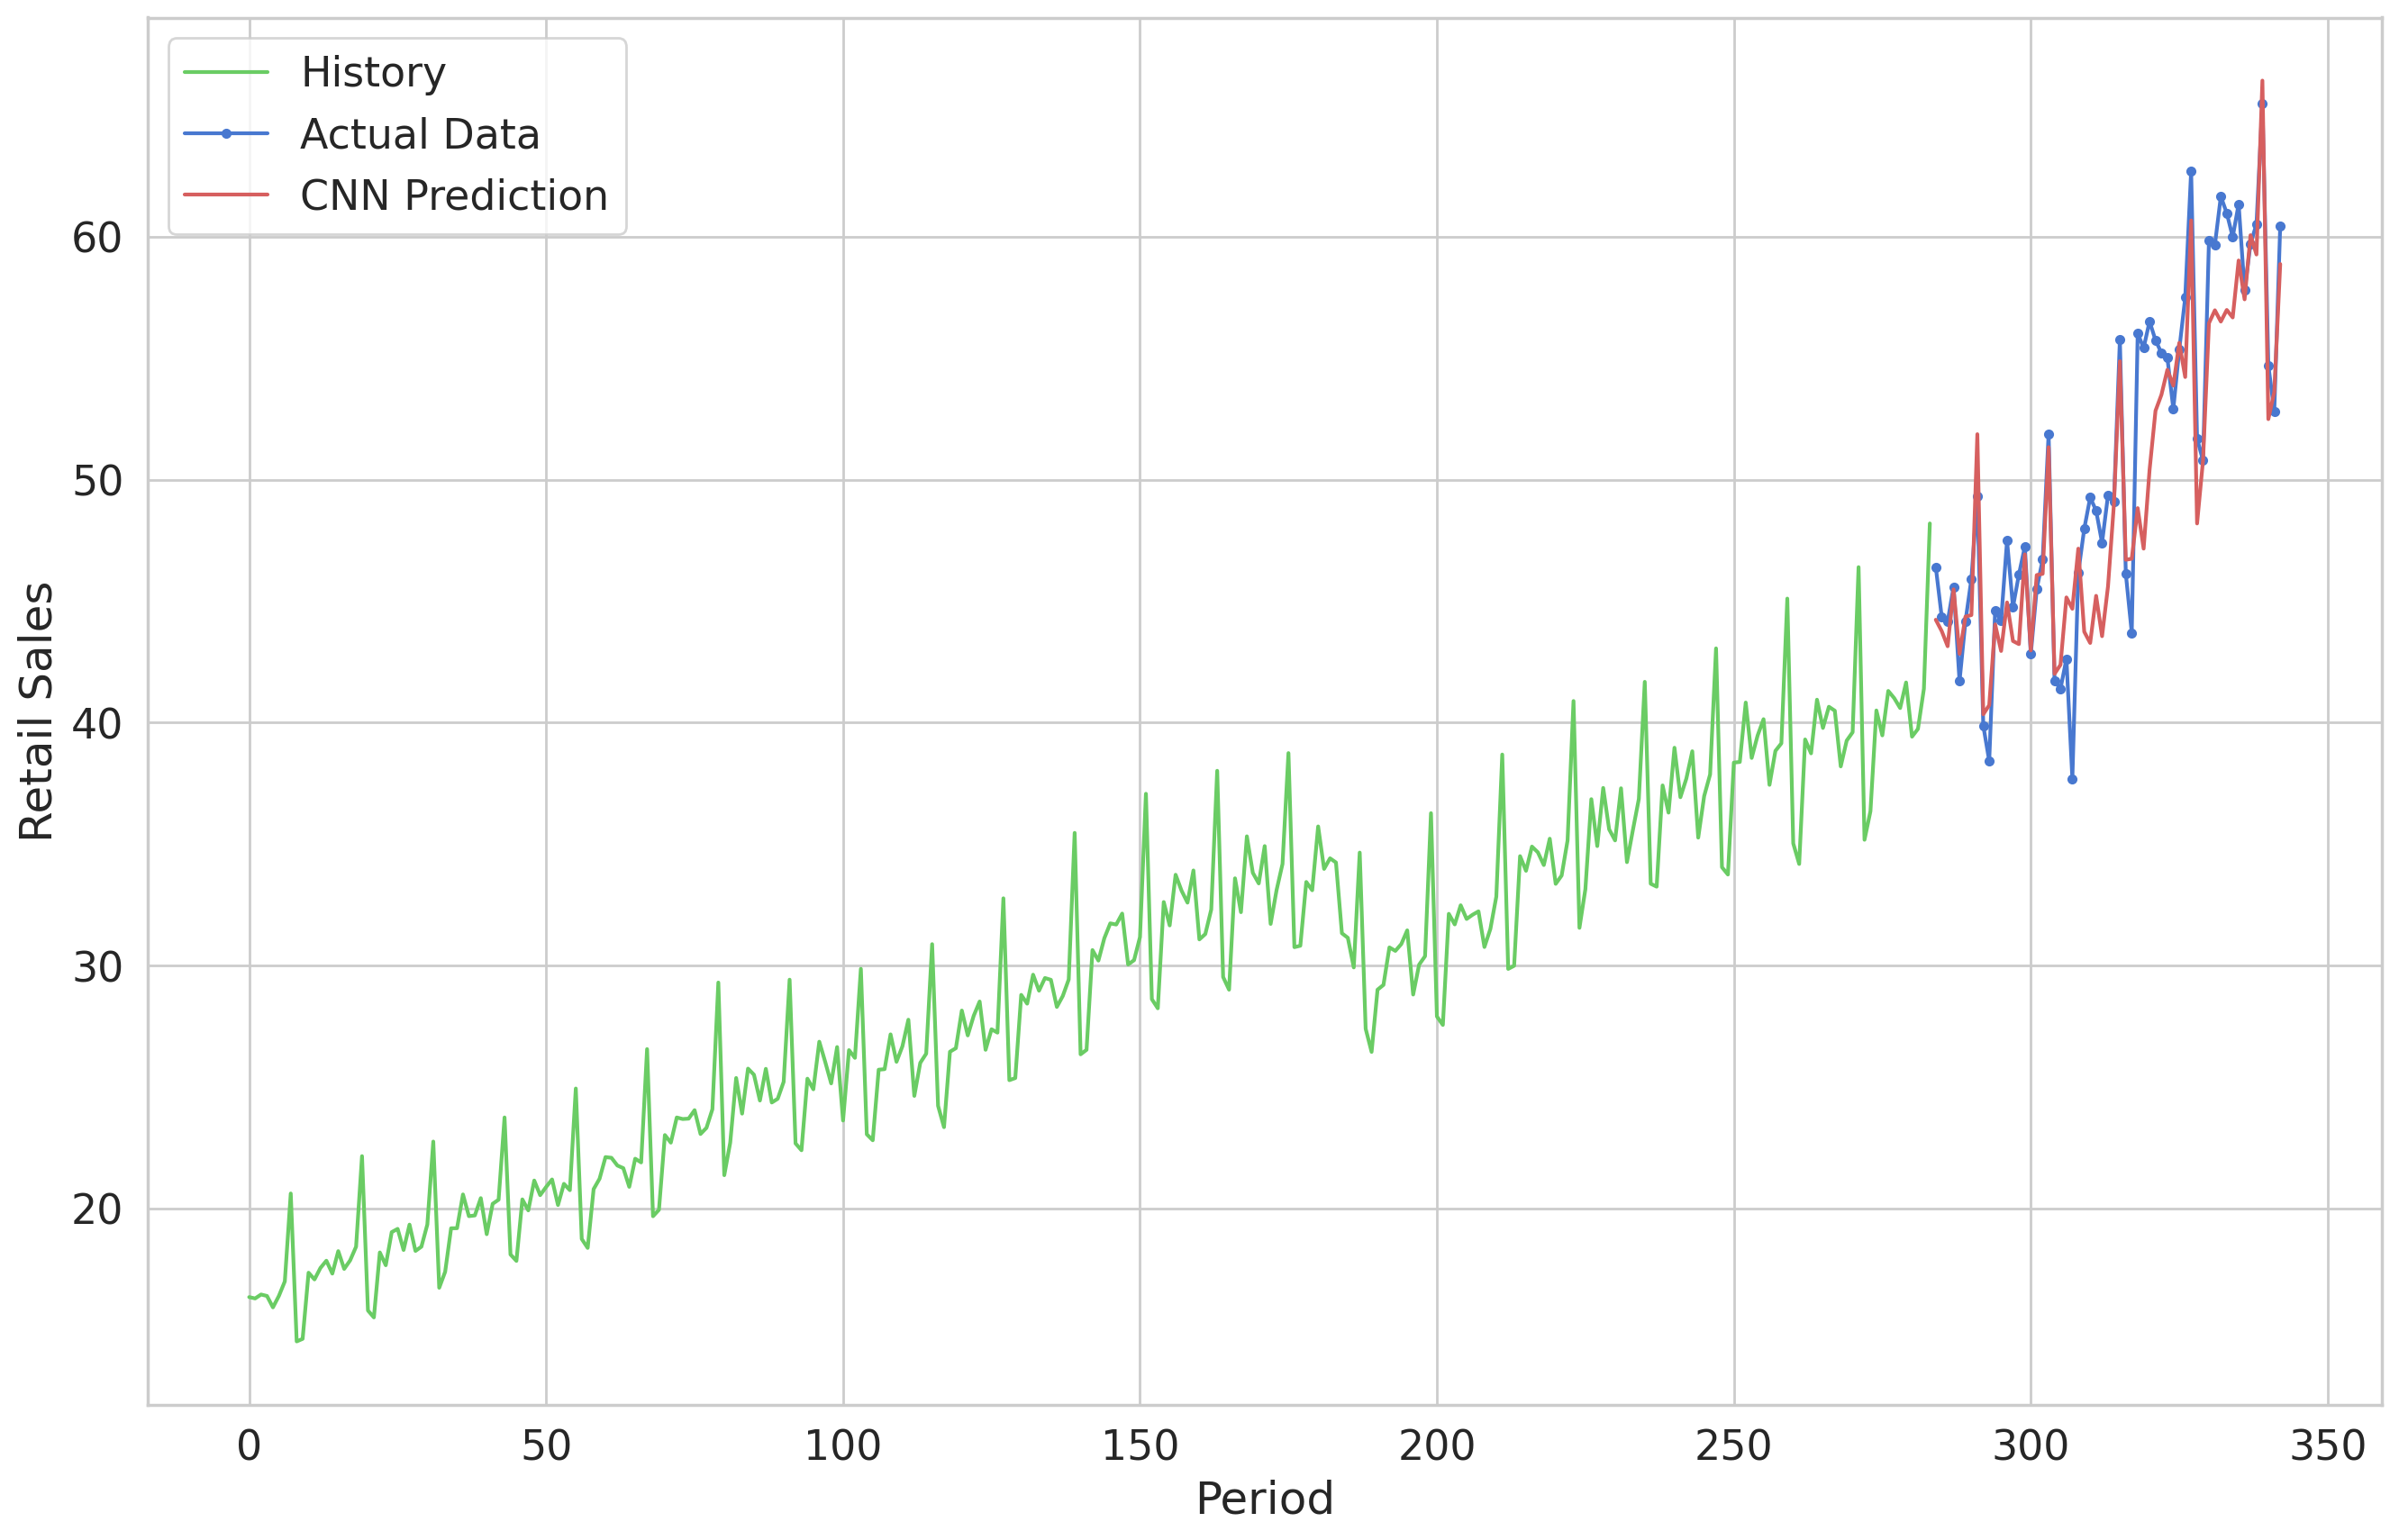

In [108]:
# Plot historical retail sales data in green
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
# Plot actual retail sales data in blue
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
# Plot predicted retail sales data in red
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="CNN Prediction")
# Set y-axis label to "Retail Sales"
plt.ylabel('Retail Sales')
# Set x-axis label to "Period"
plt.xlabel('Period')
# Displays legend showing which line corresponds to which data
plt.legend()
# Display the plot
plt.show();

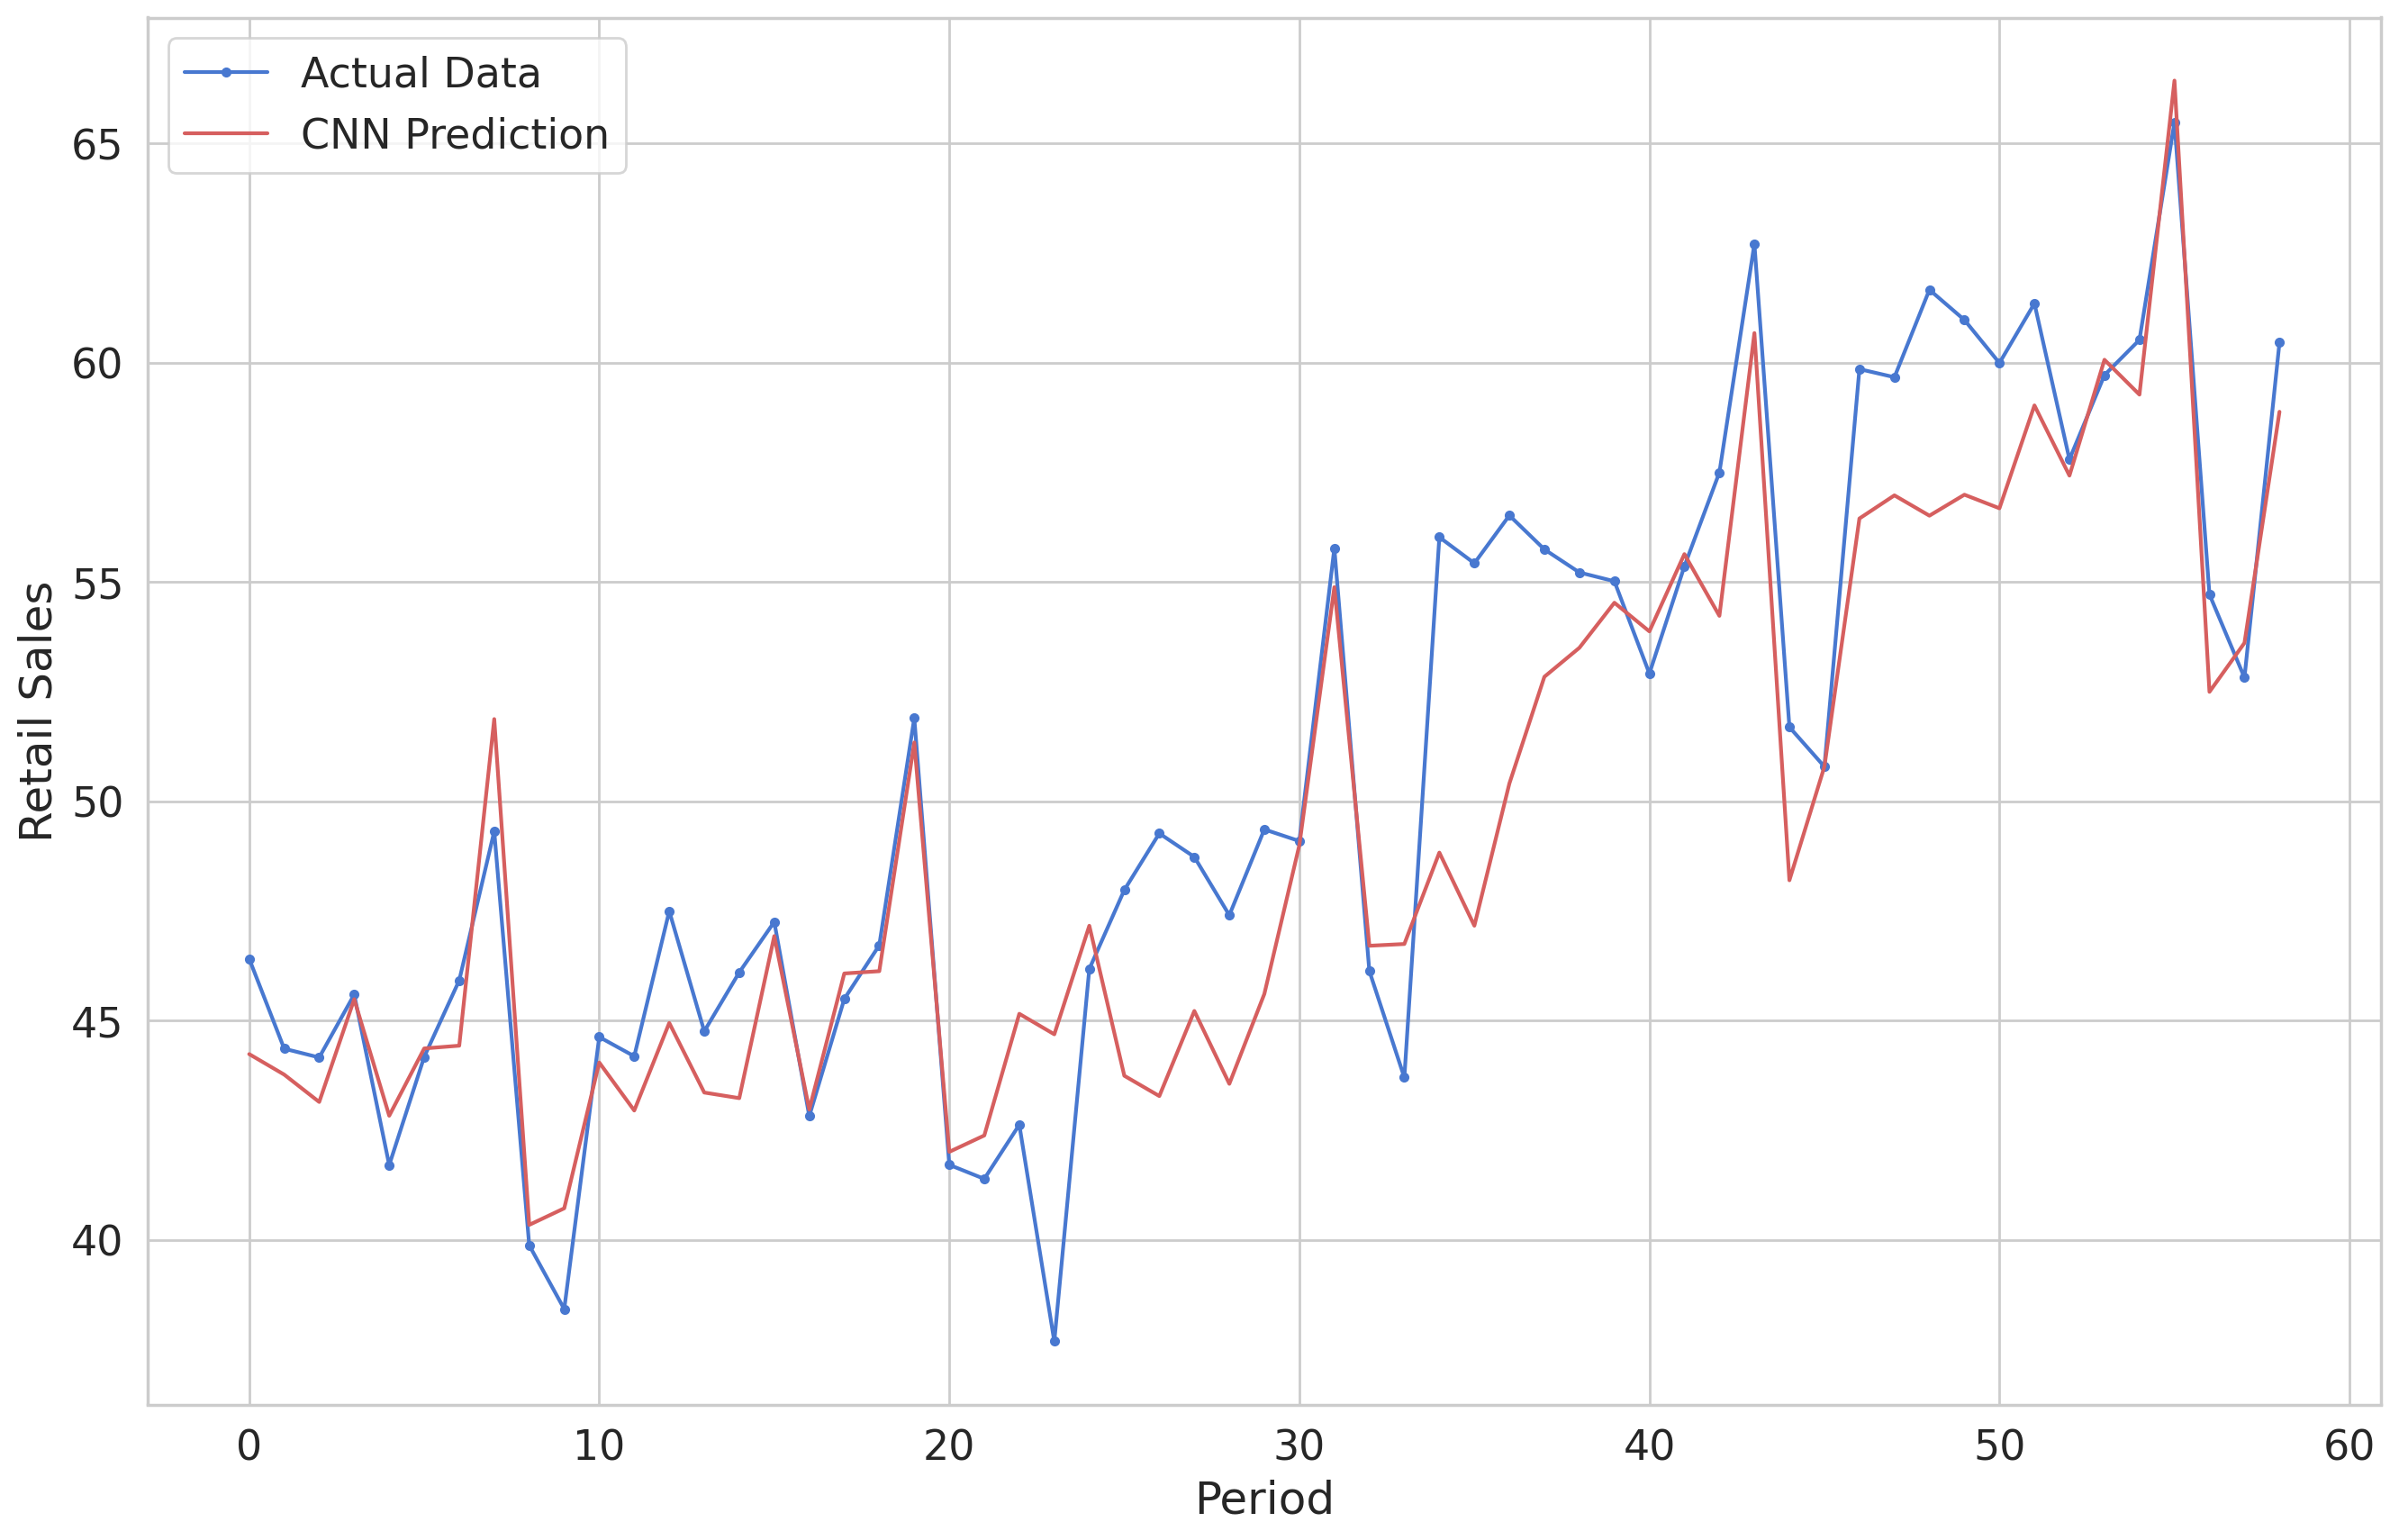

In [109]:
# Plot actual retail sales data in blue
plt.plot(y_test, marker='.', label="Actual Data")
# Plot predicted retail sales data in red
plt.plot(y_pred, 'r', label="CNN Prediction")
# Set y-axis label to "Retail Sales"
plt.ylabel('Retail Sales')
# Set x-axis label to "Period"
plt.xlabel('Period')
# Displays legend showing which line corresponds to which data
plt.legend()
# Display the plot
plt.show();


# Modeling - using MLP

In [104]:
# define model
model_mlp = Sequential()
model_mlp.add(Dense(50, activation='relu', input_dim=n_steps))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['mae', 'mse'])

# fit model
history_mlp = model_mlp.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)
y_pred_mlp = model_mlp.predict(x_test)

Epoch 1/500
8/8 [==============================] - 1s 29ms/step - loss: 1195.0106 - mae: 34.1072 - mse: 1195.0106 - val_loss: 1791.4337 - val_mae: 42.2343 - val_mse: 1791.4337
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 638.5464 - mae: 24.9308 - mse: 638.5464 - val_loss: 914.5383 - val_mae: 30.1149 - val_mse: 914.5383
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 308.2528 - mae: 17.2960 - mse: 308.2528 - val_loss: 413.9495 - val_mae: 20.1520 - val_mse: 413.9495
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 134.3925 - mae: 11.3375 - mse: 134.3925 - val_loss: 164.5530 - val_mae: 12.5387 - val_mse: 164.5530
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 48.6119 - mae: 6.6393 - mse: 48.6119 - val_loss: 49.6522 - val_mae: 6.5121 - val_mse: 49.6522
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 13.8930 - mae: 3.2372 - mse: 13.8930 - val_loss: 11.8043 - val_mae: 2.8253

# **Comparing the two models' performance**

Comparison of mean absolute errors

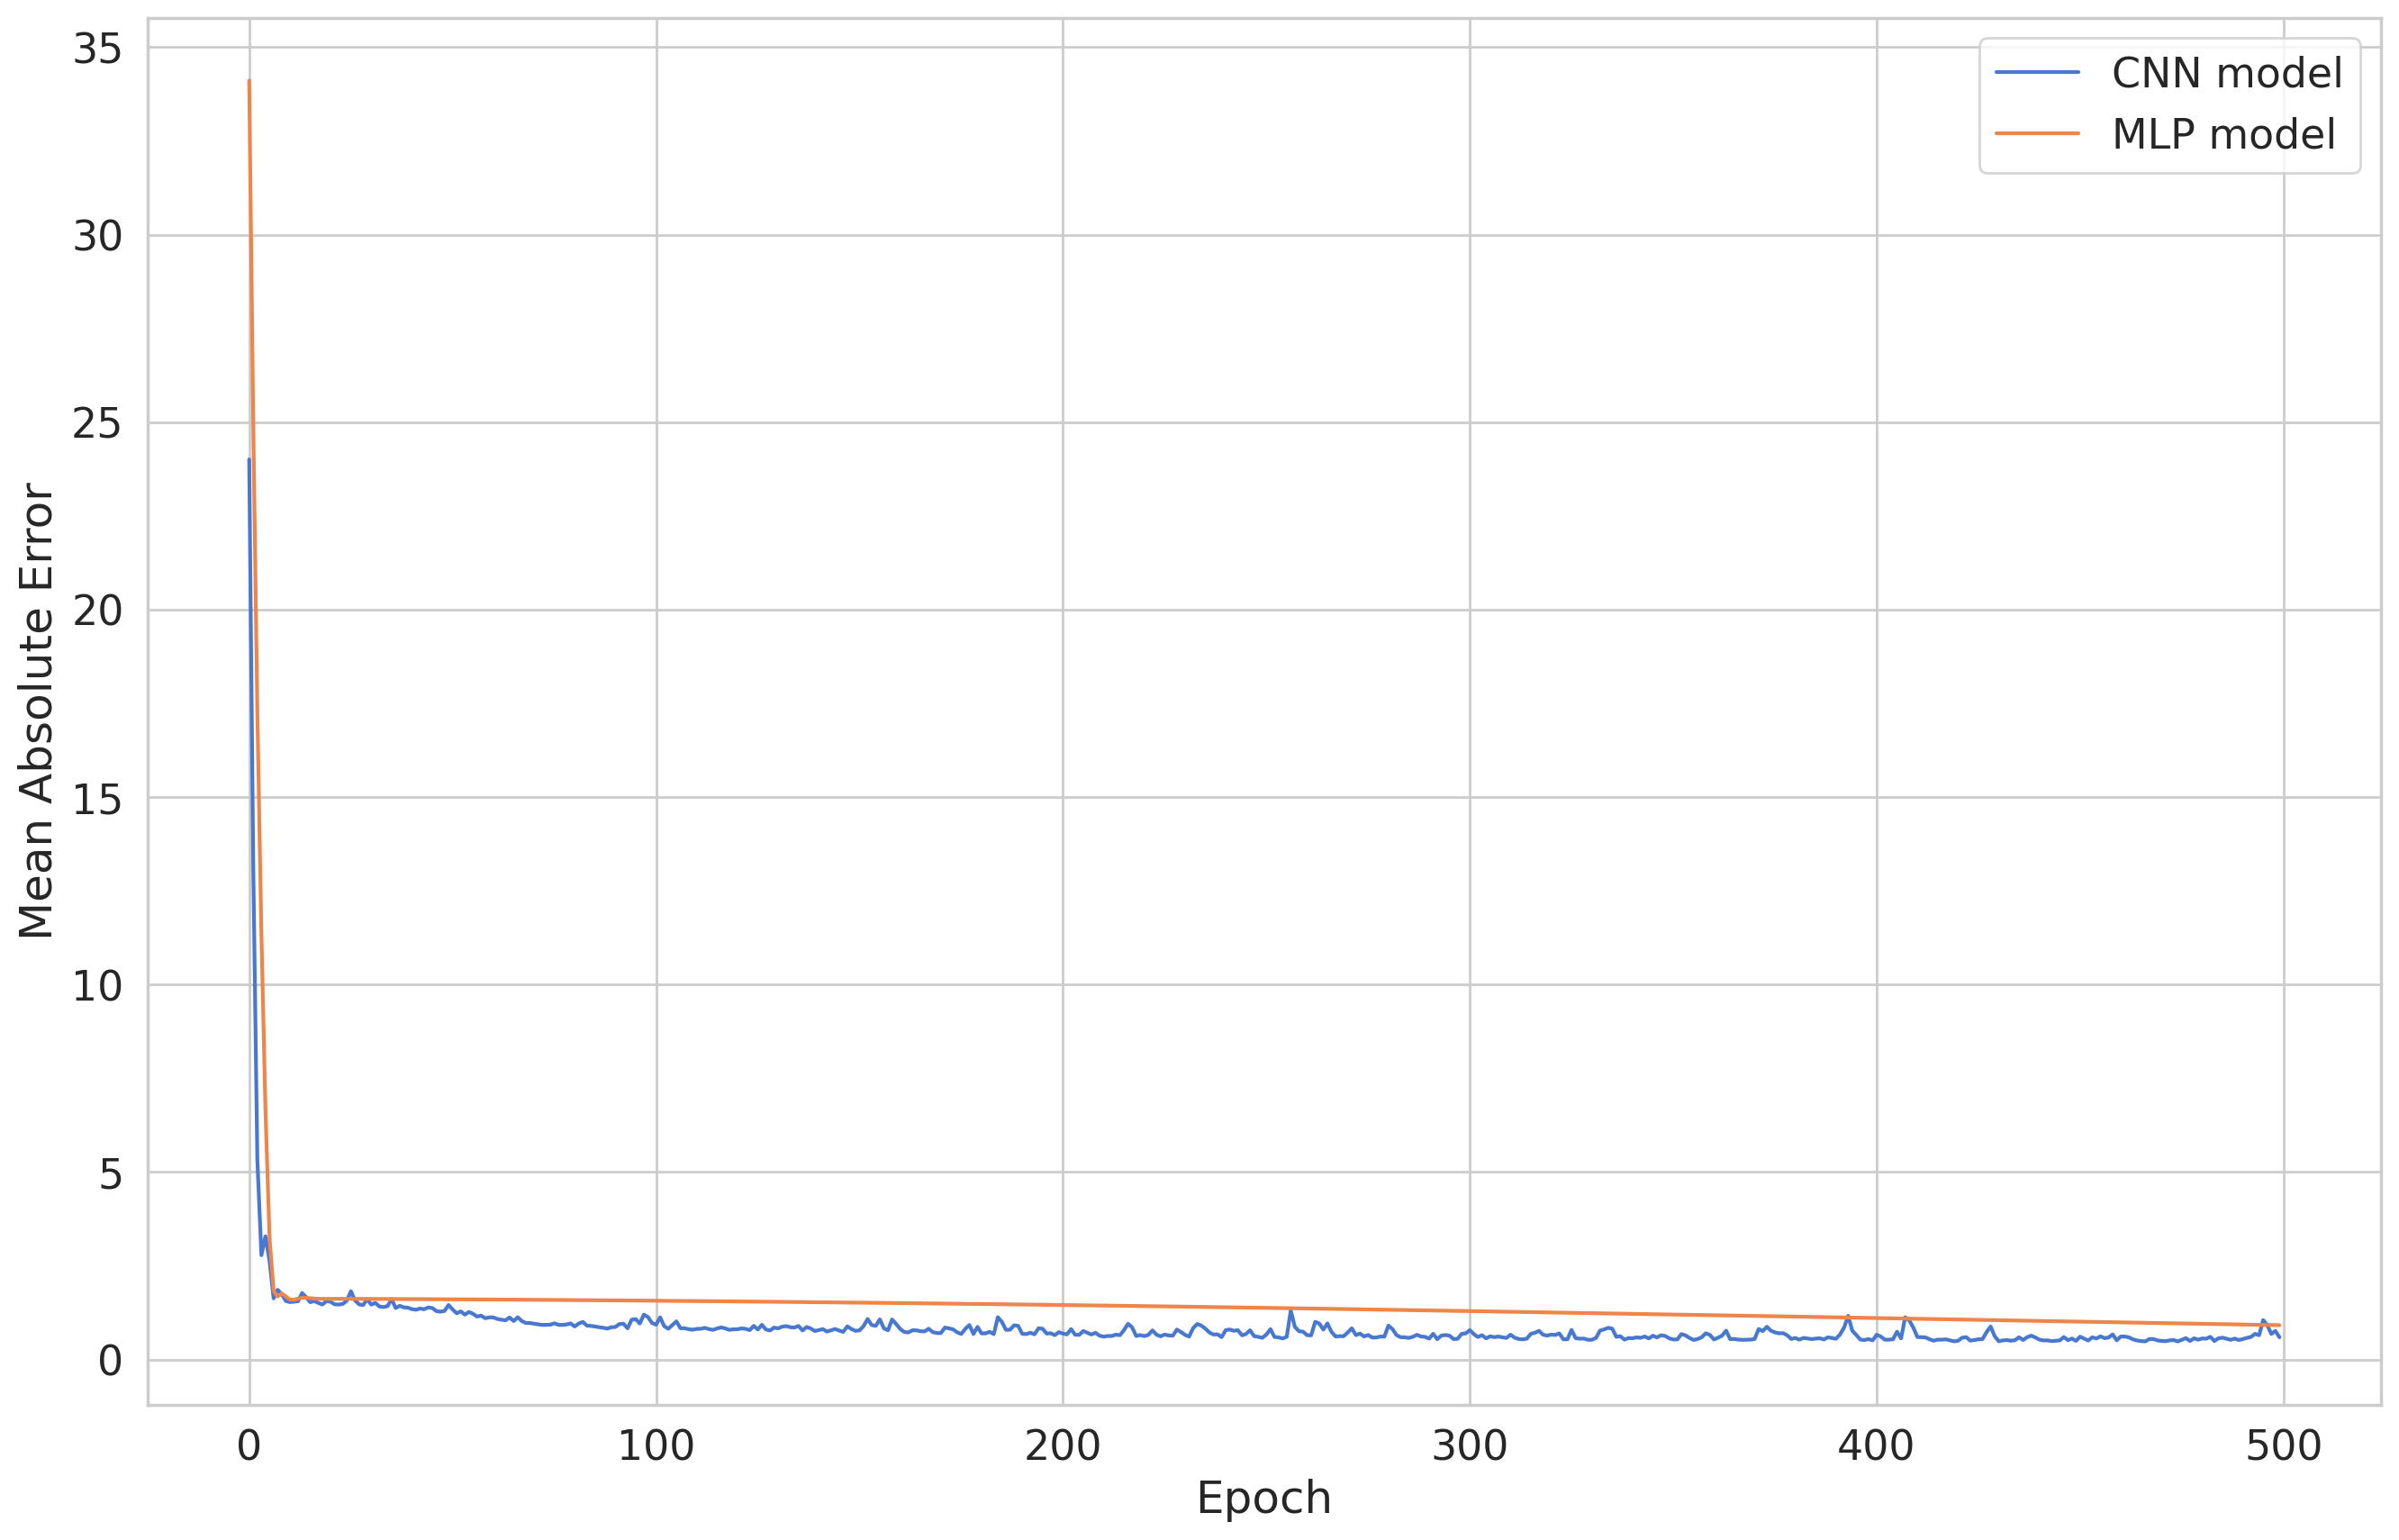

In [110]:
plt.plot(history.history['mae'], label="CNN model")
plt.plot(history_mlp.history['mae'], label="MLP model")
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Comparison of mean squared error

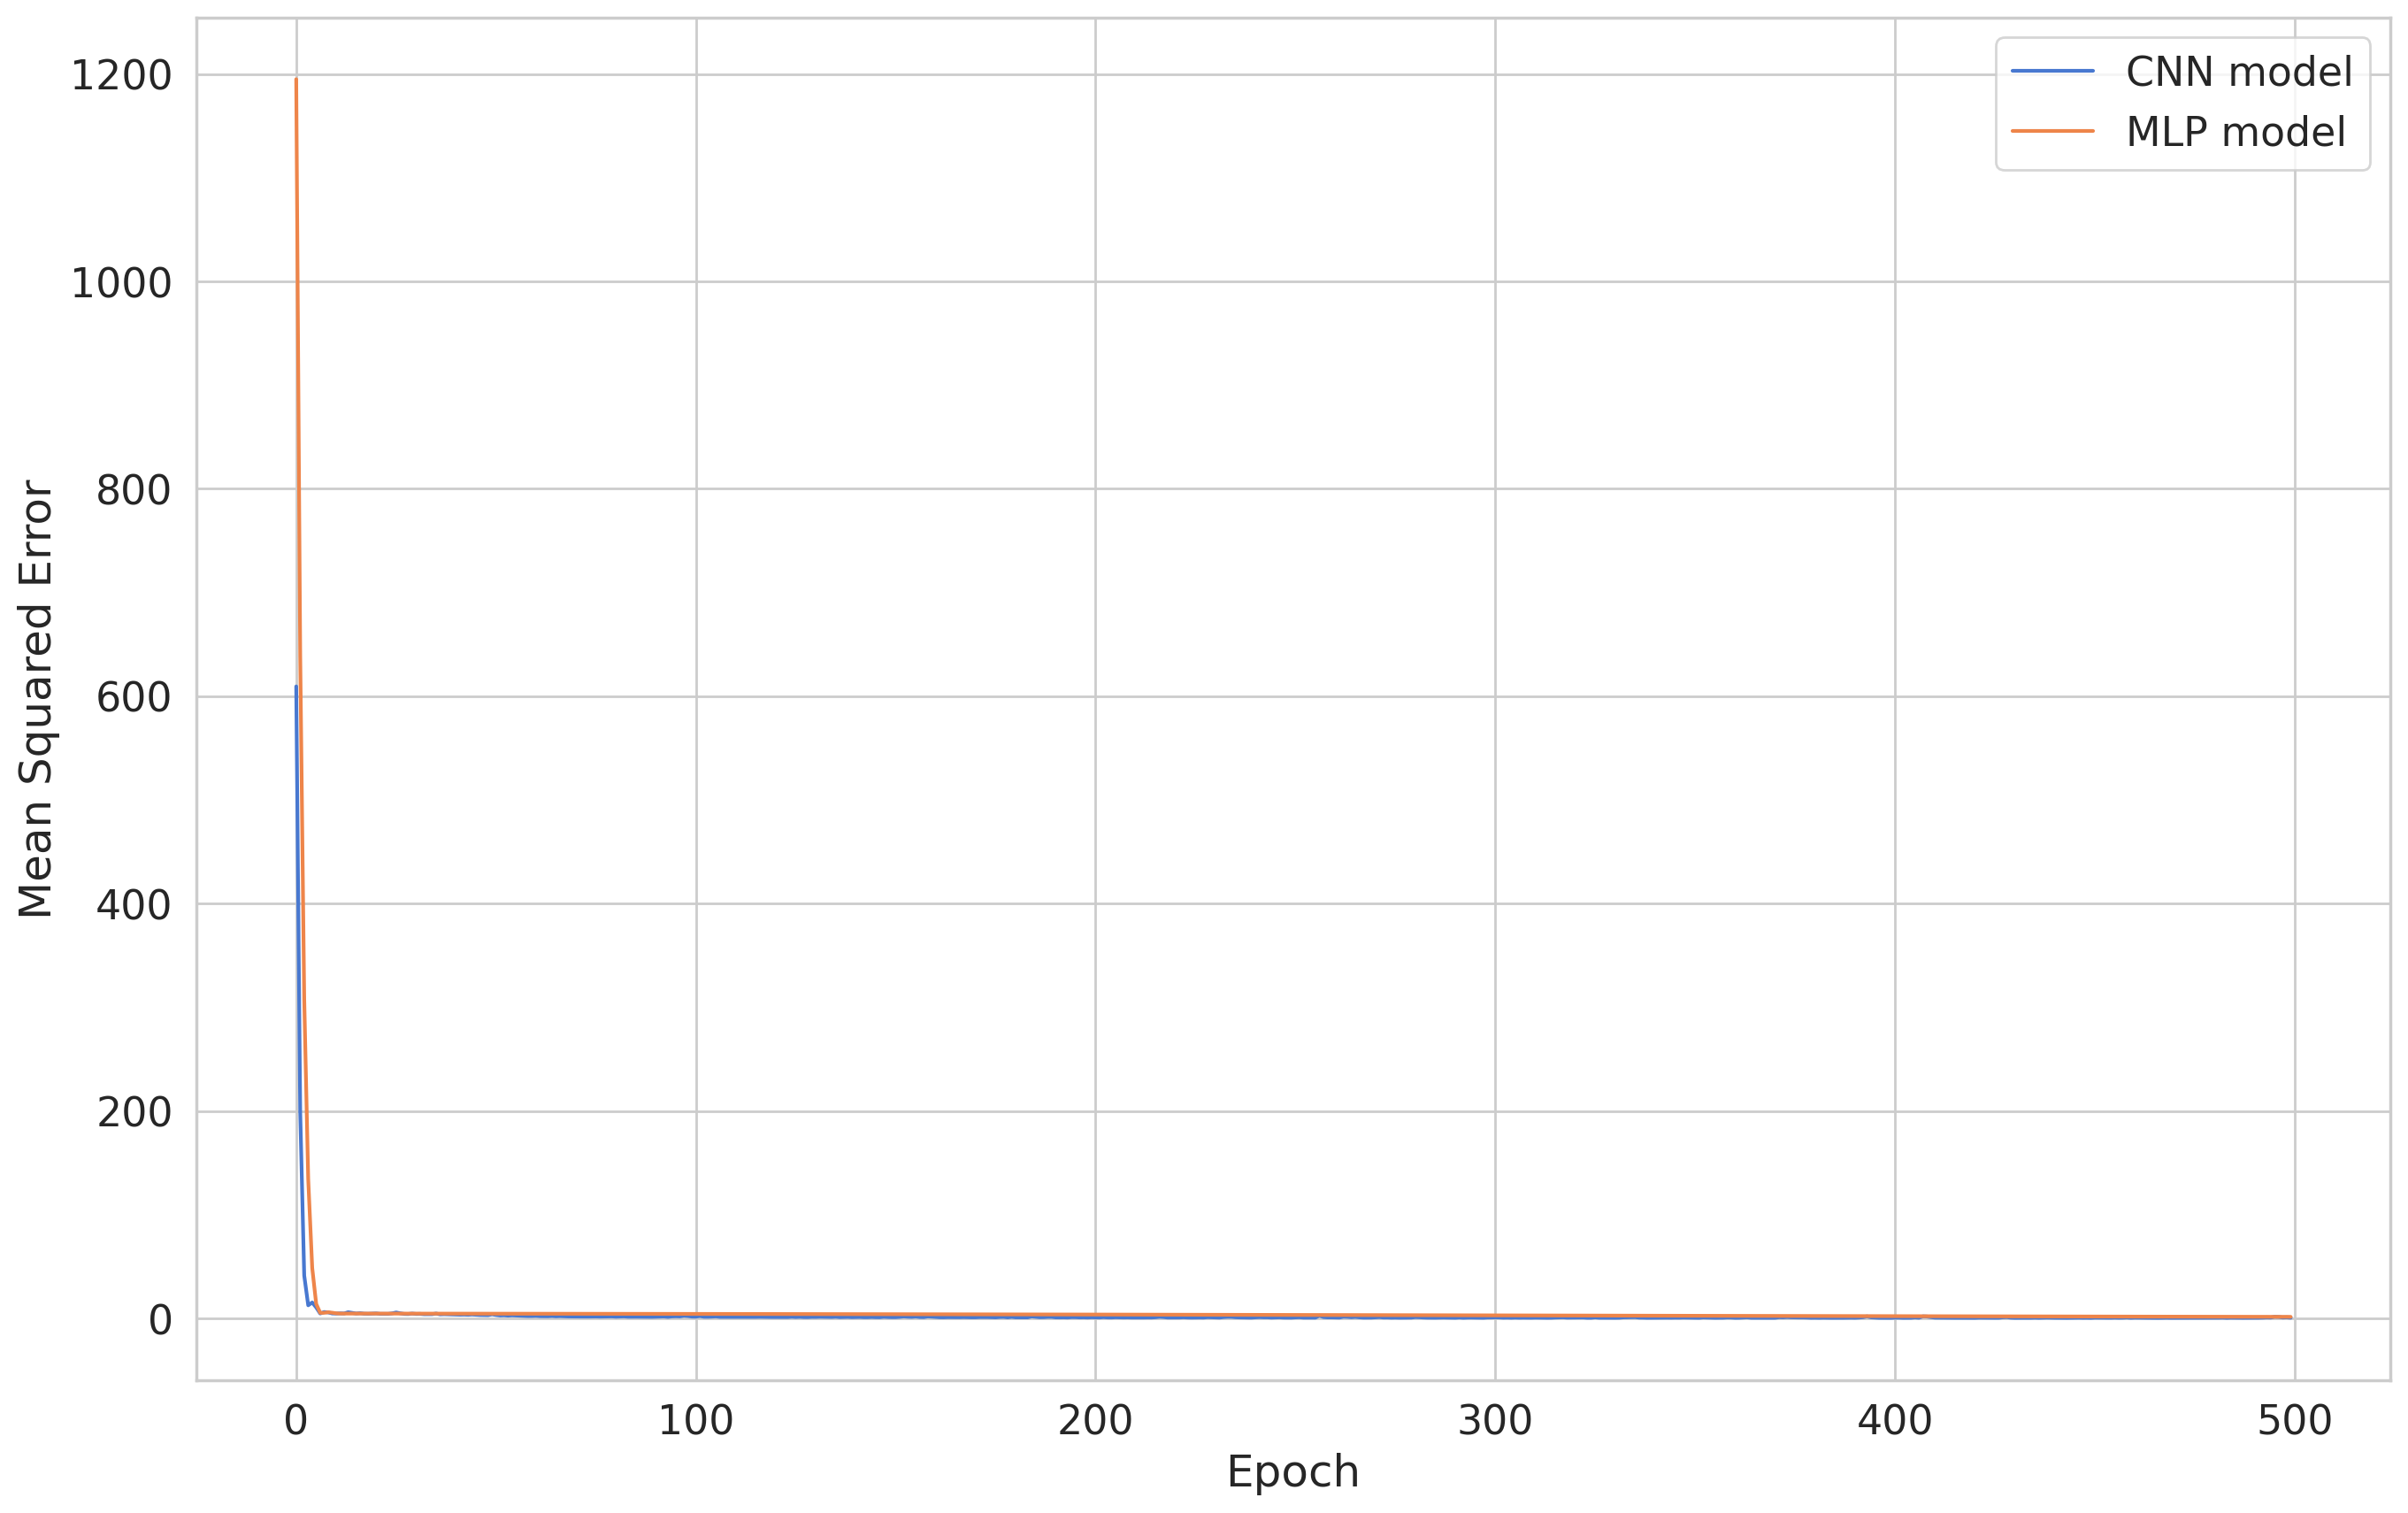

In [105]:
plt.plot(history.history['mse'], label="CNN model")
plt.plot(history_mlp.history['mse'], label="MLP model")
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Plotting the original data with prediction of CNN model and of MLP model

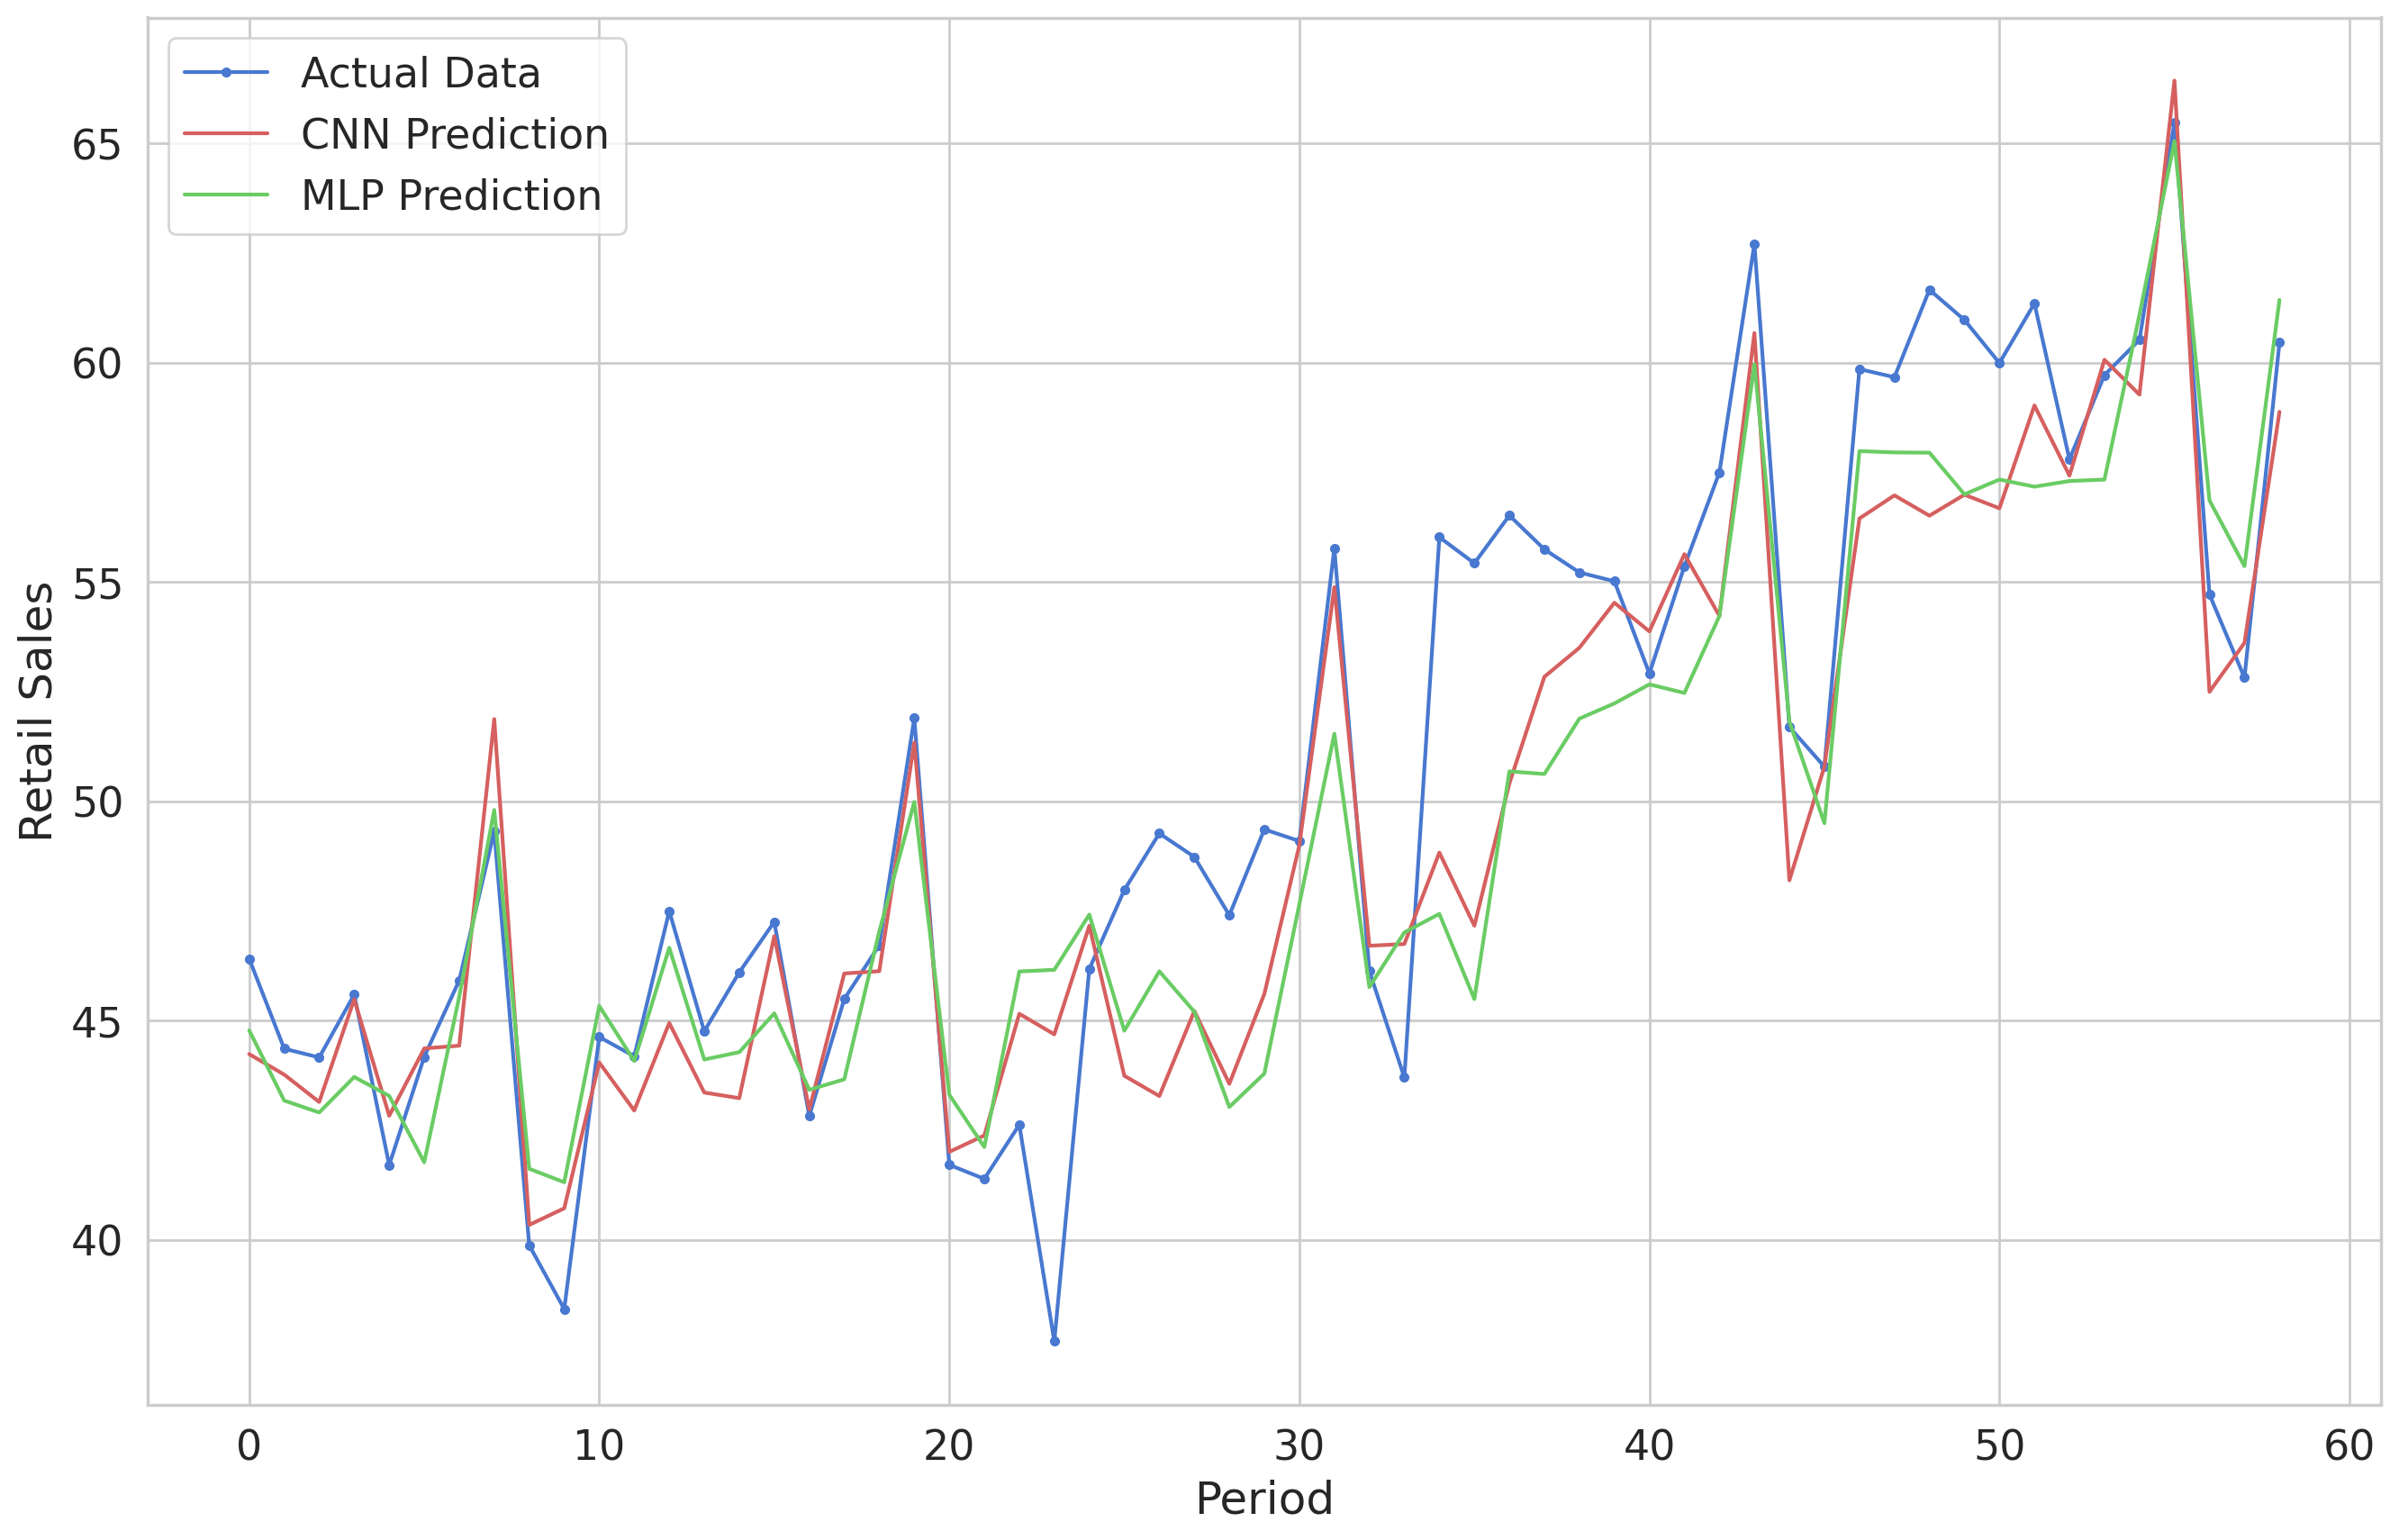

In [106]:
# Plot actual retail sales data in blue
plt.plot(y_test, marker='.', label="Actual Data")
# Plot predicted retail sales data in red
plt.plot(y_pred, 'r', label="CNN Prediction")
plt.plot(y_pred_mlp, 'g', label="MLP Prediction")
# Set y-axis label to "Retail Sales"
plt.ylabel('Retail Sales')
# Set x-axis label to "Period"
plt.xlabel('Period')
# Displays legend showing which line corresponds to which data
plt.legend()
# Display the plot
plt.show();
